In [451]:
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score , recall_score, precision_score

from tabulate import tabulate

import plotly.express as px
import pandas as pd

from ipywidgets import interact, interactive, fixed, interact_manual, Layout
import ipywidgets as widgets

from IPython.display import HTML

import numpy as np

import pylab as plt


In [3]:
pd.options.display.notebook_repr_html = True

In [6]:
try:
    dadosIn = pd.read_csv('pima-indians-diabetes.data.csv')
except IOError as err:
    print err

In [7]:
dadosIn.columns

Index([u'Pregnancies', u'Glucose', u'BloodPressure', u'SkinThickness',
       u'Insulin', u'BMI', u'DiabetesPedigreeFunction', u'Age', u'Class'],
      dtype='object')

In [31]:
def get(data, coluna): return data.loc[:,[coluna]]

In [21]:
classificador = SGDClassifier()

X = dadosIn.drop(columns='Class');

y = dadosIn.loc[:, ['Class']] 

In [349]:
percetagemTeste= 0.2

In [350]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=percetagemTeste)

In [351]:
classificador.fit(X_train,y_train);

resultado = classificador.predict(X_test)

precisao =  (resultado ^ y_test.Class.values)

In [438]:
print "% Acertos: {0:.2f}".format(1-(sum(precisao))/float(len(precisao)))

% Acertos: 0.57


In [439]:
print classification_report(resultado,y_test)

              precision    recall  f1-score   support

           0       0.48      0.76      0.59        63
           1       0.73      0.44      0.55        91

   micro avg       0.57      0.57      0.57       154
   macro avg       0.61      0.60      0.57       154
weighted avg       0.63      0.57      0.57       154



In [325]:
display(HTML( tabulate (confusion_matrix(resultado,y_test), tablefmt='html') ))

30,21
70,33


### Parte interativa

In [339]:
def gera(num):
    X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=num)
    
    classificador.fit(X_train,y_train);

    resultado = classificador.predict(X_test)
 
    return (classification_report(resultado,y_test)  ,
            "<B>matriz de confusao: <BR> "+ tabulate (confusion_matrix(resultado,y_test), tablefmt='html') )

In [355]:
caption = widgets.Textarea(value='classification_report', layout=Layout(width='70%') )
caption.rows = 10 #Recomendavel usar o @interact no jupyter web

caption2 = widgets.HTML( )
slider = widgets.FloatSlider(min=0.1, max=0.99, step=0.01, description=' Teste')

def handle_slider_change(change):
    caption.value,caption2.value = gera(change.new)
    
slider.observe(handle_slider_change, names='value')

display(slider,caption)
display(caption2)

FloatSlider(value=0.1, description=u' Teste', max=0.99, min=0.1, step=0.01)

Textarea(value=u'classification_report', layout=Layout(width=u'70%'), rows=10)

HTML(value=u'')

Analise com % subamostrado da base de dados:

In [385]:
def gera2(num):
    X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=num,random_state=777)
    
    classificador.fit(X_train,y_train);

    resultado = classificador.predict(X_test)
 
    precisao =  (resultado ^ y_test.Class.values)
    
    return (1-(sum(precisao))/float(len(precisao)))  #retorna micro avg

In [496]:
def geraScore(num=.5, score=accuracy_score):
    global X
    global y
    X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=num)
    
    classificador.fit(X_train,y_train);

    resultado = classificador.predict(X_test)
    
    return score(resultado,y_test)
  
    

In [400]:
testett = np.arange(0.1,.9,0.01) #demora
res =[ map(gera2,testett ) for x in range(10) ]

In [420]:
np.array(res).mean(0).shape

(80L,)

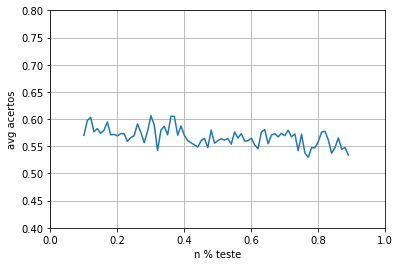

In [433]:
plt.plot(testett, np.array(res).mean(0)); plt.grid() ; 

plt.xlabel('n % teste') ; plt.ylabel('avg acertos') ;plt.axis([0 , 1, 0.4, 0.8]);

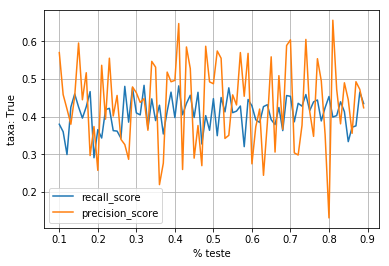

In [499]:
ress_rs = np.array ( [ map(lambda valor: geraScore(valor, recall_score) ,testett ) 
         for x in range(10)] ).mean(0) #repita 10 vezes e tira a média

ress_ps = np.array ( [ map(lambda valor: geraScore(valor, precision_score) ,testett ) 
         for x in range(10)] ).mean(0)

plt.plot(testett, ress_rs, label='recall_score');  

plt.plot(testett, ress_ps, label='precision_score'); plt.grid(); plt.legend();
plt.xlabel('% teste'); plt.ylabel('taxa: True');

In [392]:
%%html
<style>
textarea, input {
    font-family: consolas;
}
</style>

refazendo com threading, porque estes for deixam lento:

In [509]:
from threading import Thread
from threading import Lock

In [512]:
my_mutex = Lock()

In [538]:
class Th(Thread):

    def __init__ (self, id):
        Thread.__init__(self)
        self.id = id
        
    def geraScores(self,num=.5, score=accuracy_score):
        global X
        global y
        global my_mutex
        
        my_mutex.acquire() #fiz aqui um deadlock e não sei como arruma
        
        X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=num)

        my_mutex.release()
        
        classificador.fit(X_train,y_train);

        resultado = classificador.predict(X_test)

        return score(resultado,y_test)

    def fazerrecall_score(self):        
        testett = np.arange(0.1,.9,0.01)
        return np.array ([map(lambda valor: self.geraScores(valor,recall_score),testett) for x in range(10)]).mean(0)

    def fazerprecision_score(self):      
        testett = np.arange(0.1,.9,0.01)
        return np.array ([map(lambda valor: self.geraScores(valor,precision_score),testett) for x in range(10)]).mean(0)
    
    def run(self):
        global MutexA
        global MutexB
        
        print "iniciou" + str(self.id)
        if(self.id==1):
            MutexA = self.fazerrecall_score()
            print 'pronto id:' + str(self.id)
            
        if(self.id==2):
            MutexB = self.fazerprecision_score()
            print 'pronto id:' + str(self.id)   
                    
     
        pass    



In [542]:
MutexA = 0
MutexB = 0

a = Th(1)
a.start() 

#b = Th(2)
#b.start() 

a.join()
 

iniciou1
iniciou2


In [ ]:
MutexA+3

### Análises curiosas:

In [311]:
#px.histogram(data_frame=dadosIn, x='Age', facet_col='Class',  nbins=30)

In [154]:
dadosIn.columns

Index([u'Pregnancies', u'Glucose', u'BloodPressure', u'SkinThickness',
       u'Insulin', u'BMI', u'DiabetesPedigreeFunction', u'Age', u'Class'],
      dtype='object')

In [312]:
#px.scatter(data_frame=dadosIn, x='Age', y='Glucose',facet_col='Class' ,color='Insulin')